In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.endpoints.playerdashptshotdefend import PlayerDashPtShotDefend

In [2]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [3]:
from nba_api.stats.endpoints.commonteamroster import CommonTeamRoster

In [4]:
headers= {
    'Host': 'stats.nba.com', 
    'Connection': 'keep-alive', 
    'Accept': 'application/json, text/plain, */*', 
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36', 
    'Referer': 'https://stats.nba.com/', 
    'Accept-Encoding': 'gzip, deflate, br', 
    'Accept-Language': 'en-US,en;q=0.9',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
}

In [5]:
def hustle_url(date_from="", date_to="", season='2019-20'):
    return f"https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom={date_from}&DateTo={date_to}&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={season}&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight="

def matchup_url(player_id="203496", date_from="", date_to=""):
    """
    Default player_id is Covington's ID
    """
    return f"https://stats.nba.com/stats/matchupsrollup?DateFrom={date_from}&DateTo={date_to}&DefPlayerID={player_id}&LeagueID=00&Matchup=Defense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"

def matchup_breakdown(player_id):
    url = f"https://stats.nba.com/stats/matchupsrollup?DateFrom={date_from}&DateTo=&DefPlayerID=&LeagueID=00&Matchup=Defense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"
    data = requests.get(url=url, headers=headers).json()
    return pd.DataFrame(data=data['resultSets'][0]['rowSet'], columns=data['resultSets'][0]['headers'])

## Methods for plotting defensive chart

In [6]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False, zorder=None):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=7)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=zorder)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=zorder)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None, zorder=zorder)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [7]:
LESS_SIX = "LESS_THAN_SIX"
SIX_TEN = "SIX_TEN"
TEN_FIFTEEN = "TEN_FIFTEEN"
GREATER_FIFTEEN = "GREATER_FIFTEEN"
THREE_POINTER = "THREE_POINTER"

def_dist_keys = [LESS_SIX, SIX_TEN, TEN_FIFTEEN, GREATER_FIFTEEN, THREE_POINTER]

In [8]:
team_categories = [
    'Overall',
    '3 Pointers',
    '2 Pointers',
    'Less Than 6Ft',
    'Less Than 10Ft',
    'Greater Than 15Ft'
]

def get_team_defense_df(defense_category, season='2019-20'):
    url = f"https://stats.nba.com/stats/leaguedashptteamdefend?Conference=&DateFrom=&DateTo=&DefenseCategory={defense_category}&Division=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&Season={season}&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision="
    resp = requests.get(url=url, headers=headers)
    data_dict = resp.json()
    return pd.DataFrame(data=data_dict['resultSets'][0]['rowSet'], columns=data_dict['resultSets'][0]['headers'])

def get_league_averages(season = '2019-20'):
    avg_dict = {}

    category_dict = {}
    for category in team_categories:
        category_dict[category] = get_team_defense_df(defense_category=category, season=season)
        sleep(0.25)

    averaged_dicts = {}
    for category in category_dict:
        averaged_dicts[category] = category_dict[category].mean()

    greater_fifteen_two_fga_avg = averaged_dicts['Greater Than 15Ft'].FGA_GT_15 - averaged_dicts['3 Pointers'].FG3A
    greater_fifteen_two_fgm_avg = averaged_dicts['Greater Than 15Ft'].FGM_GT_15 - averaged_dicts['3 Pointers'].FG3M

    ten_fifteen_fga_avg = averaged_dicts['2 Pointers'].FG2A - greater_fifteen_two_fga_avg - averaged_dicts['Less Than 10Ft'].FGA_LT_10
    ten_fifteen_fgm_avg = averaged_dicts['2 Pointers'].FG2M - greater_fifteen_two_fgm_avg - averaged_dicts['Less Than 10Ft'].FGM_LT_10

    six_ten_fga_avg = averaged_dicts['Less Than 10Ft'].FGA_LT_10 - averaged_dicts['Less Than 6Ft'].FGA_LT_06
    six_ten_fgm_avg = averaged_dicts['Less Than 10Ft'].FGM_LT_10 - averaged_dicts['Less Than 6Ft'].FGM_LT_06
    
    avg_dict = {
        LESS_SIX: averaged_dicts['Less Than 6Ft'].FGM_LT_06 / averaged_dicts['Less Than 6Ft'].FGA_LT_06,
        SIX_TEN: six_ten_fgm_avg / six_ten_fga_avg,
        TEN_FIFTEEN: ten_fifteen_fgm_avg / ten_fifteen_fga_avg,
        GREATER_FIFTEEN: greater_fifteen_two_fgm_avg / greater_fifteen_two_fga_avg,
        THREE_POINTER: averaged_dicts['3 Pointers'].FG3M / averaged_dicts['3 Pointers'].FG3A
    }
    return avg_dict

In [9]:
def get_defend_data(player_id, date_to="", date_from="", per_game: bool=False, season = "2019-20"):
    defend_data = PlayerDashPtShotDefend(player_id=player_id, team_id=0, date_from_nullable=date_from, date_to_nullable=date_to, per_mode_simple='PerGame' if per_game else 'Totals', season=season)
    
    defend_df = defend_data.get_data_frames()[0]
    
    less_than_10 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Less Than 10 Ft'].iloc[0]
    less_than_6 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Less Than 6 Ft'].iloc[0]
    greater_than_15 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Greater Than 15 Ft'].iloc[0]
    two_point = defend_df.loc[defend_df.DEFENSE_CATEGORY == '2 Pointers'].iloc[0]
    three_point = defend_df.loc[defend_df.DEFENSE_CATEGORY == '3 Pointers'].iloc[0]

    greater_fifteen_two_fga = greater_than_15.D_FGA - three_point.D_FGA
    greater_fifteen_two_fgm = greater_than_15.D_FGM - three_point.D_FGM

    ten_fifteen_fga = two_point.D_FGA - greater_fifteen_two_fga - less_than_10.D_FGA
    ten_fifteen_fgm = two_point.D_FGM - greater_fifteen_two_fgm - less_than_10.D_FGM

    six_ten_fga = less_than_10.D_FGA - less_than_6.D_FGA
    six_ten_fgm = less_than_10.D_FGM - less_than_6.D_FGM
    
    made_dict = {
        LESS_SIX: less_than_6.D_FGM,
        SIX_TEN: six_ten_fgm,
        TEN_FIFTEEN: ten_fifteen_fgm,
        GREATER_FIFTEEN: greater_fifteen_two_fgm,
        THREE_POINTER: three_point.D_FGM
    }
    attempt_dict = {
        LESS_SIX: less_than_6.D_FGA,
        SIX_TEN: six_ten_fga,
        TEN_FIFTEEN: ten_fifteen_fga,
        GREATER_FIFTEEN: greater_fifteen_two_fga,
        THREE_POINTER: three_point.D_FGA
    }
    return made_dict, attempt_dict
    
    

In [10]:
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path

def get_six_feet_arc(color):
    vertices = [
        [40, -47.5],
        [140, 96],
        [-139, 98],
        [-40, -47.5],
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_six_ten_feet_arc(color):
    vertices = [
        [-90, -47.5],
        [-162, 150],
        [162, 150],
        [90, -47.5],
        [38, -47.5],
        [140, 96],
        [-139, 98],
        [-38, -47.5],   
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 

            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_ten_fifteen_arc(color):
    vertices = [
        [-144, -47.5],
        [-200, 215],
        [200, 215],
        [144, -47.5],
        [90, -47.5],
        [162, 150],
        [-162, 150],
        [-90, -47.5],
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)
    
def get_greater_fifteen(color):
    vertices = [
        [-220, -47.5],
        [-220, 90.5],
        [-130, 285],
        [130, 285],
        [220, 90.5],
        [220, -47.5],
        [144, -47.5],
        [200, 215],
        [-200, 215],
        [-144, -47.5],
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 

            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_three_point_area(color):
    vertices = [
        [-250, -47.5],
        [-220, -47.5],
        [-220, 90.5],
        [-142, 285],
        [142, 285],
        [220, 90.5],
        [220, -47.5],
        [250, -47.5],
        [250, 160],
        [190, 370],
        [-190, 370],
        [-250, 160]
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO,
             Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.LINETO, Path.LINETO,
             Path.CURVE4, Path.CURVE4, Path.CURVE4,
            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=3, lw=0)

In [11]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

In [12]:
def plot_texts(ax, made_dict, attempt_dict, six_pct, six_ten_pct, 
               ten_fifteen_pct, greater_fifteen_pct, three_pointer_pct, is_per_game=False):
    plt.style.use('fivethirtyeight')
    alpha = 0.6
    if not is_per_game:
        ax.text(x=0, y=20, s=f"{made_dict[LESS_SIX]} / {attempt_dict[LESS_SIX]}\n{six_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=70, s=f"{made_dict[SIX_TEN]} / {attempt_dict[SIX_TEN]}\n{six_ten_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=120,
                s=f"{made_dict[TEN_FIFTEEN]} / {attempt_dict[TEN_FIFTEEN]}\n{ten_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=170,
                s=f"{made_dict[GREATER_FIFTEEN]} / {attempt_dict[GREATER_FIFTEEN]}\n{greater_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=260, s=f"{made_dict[THREE_POINTER]} / {attempt_dict[THREE_POINTER]}\n{three_pointer_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
    else:
        ax.text(x=0, y=20, s=f"{made_dict[LESS_SIX]:.2f} / {attempt_dict[LESS_SIX]:.2f}\n{six_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=70, s=f"{made_dict[SIX_TEN]:.2f} / {attempt_dict[SIX_TEN]:.2f}\n{six_ten_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=120,
                s=f"{made_dict[TEN_FIFTEEN]:.2f} / {attempt_dict[TEN_FIFTEEN]:.2f}\n{ten_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=170,
                s=f"{made_dict[GREATER_FIFTEEN]:.2f} / {attempt_dict[GREATER_FIFTEEN]:.2f}\n{greater_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=260, s=f"{made_dict[THREE_POINTER]:.2f} / {attempt_dict[THREE_POINTER]:.2f}\n{three_pointer_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})




def plot_for_player(player_id, team_id, title, date_from="", date_to="", is_per_game=False, season='2019-20'):
    fig, ax = plt.subplots(figsize=(12, 12))
    # colors_dict = {0:'red', 1:'green'}
    made_dict, attempt_dict = get_defend_data(player_id=player_id, date_from=date_from, date_to=date_to, per_game=is_per_game, season=season)
    league_average = get_league_averages(season=season)

    texts = []
    output_list = []

    cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], n_colors=21, as_cmap=False)
    bin_res = {item: index for index, item in enumerate(list(range(-10, 11, 1)))}
    
    six_pct = made_dict[LESS_SIX]/attempt_dict[LESS_SIX]
    six_ten_pct = made_dict[SIX_TEN]/attempt_dict[SIX_TEN]
    ten_fifteen_pct = made_dict[TEN_FIFTEEN]/attempt_dict[TEN_FIFTEEN]
    greater_fifteen_pct = made_dict[GREATER_FIFTEEN]/attempt_dict[GREATER_FIFTEEN]
    three_pointer_pct = made_dict[THREE_POINTER]/attempt_dict[THREE_POINTER]
    
    six_zone_diff = np.clip((six_pct - league_average[LESS_SIX])*100,-10, 10)
    six_ten_diff = np.clip((six_ten_pct - league_average[SIX_TEN])*100,-10, 10)
    ten_fifteen_diff = np.clip((ten_fifteen_pct - league_average[TEN_FIFTEEN])*100,-10, 10)
    greater_fifteen_two_diff = np.clip((greater_fifteen_pct - league_average[GREATER_FIFTEEN])*100,-10, 10)
    three_diff = np.clip((three_pointer_pct - league_average[THREE_POINTER])*100,-10, 10)
    
    plot_texts(ax=ax, made_dict=made_dict, attempt_dict=attempt_dict, six_pct=six_pct, 
               six_ten_pct=six_ten_pct, ten_fifteen_pct=ten_fifteen_pct, greater_fifteen_pct=greater_fifteen_pct,
               three_pointer_pct=three_pointer_pct, is_per_game=is_per_game)


    # GREATER THAN 15
    ax.add_patch(get_greater_fifteen(color=cmap[bin_res[int(greater_fifteen_two_diff)]]))
    # 10-15 ft
    ax.add_patch(get_ten_fifteen_arc(color=cmap[bin_res[int(ten_fifteen_diff)]]))
    # 6-10 ft
    ax.add_patch(get_six_ten_feet_arc(color=cmap[bin_res[int(six_ten_diff)]]))
    # <6 ft
    ax.add_patch(get_six_feet_arc(color=cmap[bin_res[int(six_zone_diff)]]))
    # 3 pt
    ax.add_patch(get_three_point_area(color=cmap[bin_res[int(three_diff)]]))

    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/{season.split('-')[0]}/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(92, 252, -47, 70), zorder=7)


    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=bball_white, fontsize=12, ha='center')
    ax.text(x=90, y=365, s="BETTER\nDefending", color=bball_white, fontsize=12)
    ax.scatter(x=130, y=385, s=550, marker='o', c="#4159E1", edgecolors=bball_white)
    ax.scatter(x=147, y=385, s=550, marker='o', c="#B0E0E6", edgecolors=bball_white)
    ax.scatter(x=164, y=385, s=550, marker='o', c="#FFFF99", edgecolors=bball_white)
    ax.scatter(x=181, y=385, s=550, marker='o', c="#EF3330", edgecolors=bball_white)
    ax.scatter(x=198, y=385, s=550, marker='o', c="#AB2020", edgecolors=bball_white)
    ax.text(x=201, y=365, s="   WORSE\nDefending", color=bball_white, fontsize=12)


    # Title
    ax.set_title(title, size=20, color=bball_light_orange)
    #adjust_text(texts=texts, expand_points=(1.2, 1.9))
    
    ax.text(x=-170, y=405, s=f"Numbers (Per Game) in Boxes:", color=bball_white, fontsize=12, ha='center')
    ax.text(x=-170, y=380, s=f"Allowed FGM / Allowed FGA\nAllowed FG%", fontsize=12,
            color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': 0.6, 'edgecolor': 'black', 'boxstyle' : 'round'})

    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange, zorder=7)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    for circle in output_list:    
        ax.add_artist(circle)

### Robert Covington's defensive efficiency

In [13]:
date_from = "02/06/2020"

In [14]:
covington_id = find_players_by_full_name("Robert Covington")[0]['id']

In [15]:
hou_id = find_teams_by_full_name("Houston Rockets")[0]['id']

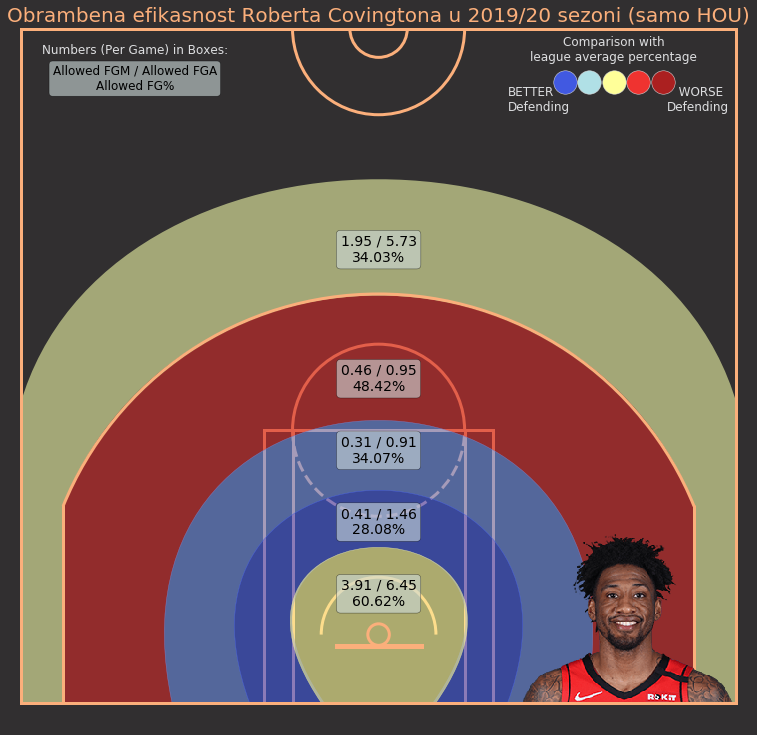

In [47]:
plot_for_player(player_id=covington_id, team_id=hou_id, title="Obrambena efikasnost Roberta Covingtona u 2019/20 sezoni (samo HOU)", date_from=date_from, is_per_game=True)

### Hustle RoCo

In [19]:
hustle_url = "https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2019-20&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight="

In [20]:
resp = requests.get(hustle_url, headers=headers)

In [21]:
json_data = resp.json()

In [25]:
df = pd.DataFrame(json_data['resultSets'][0]['rowSet'], columns=json_data['resultSets'][0]['headers'])

In [29]:
df = df.loc[(df.G > 30) & (df.MIN > 15)]

In [30]:
roco_only = df.loc[df.PLAYER_ID == covington_id]
other = df.loc[df.PLAYER_ID != covington_id]

In [43]:
derrick_jones = other.loc[other.PLAYER_NAME == "Derrick Jones Jr."]

In [34]:
top_deflections = other.sort_values(by='DEFLECTIONS', ascending=False).iloc[:8]
top_contested = other.sort_values(by='CONTESTED_SHOTS', ascending=False).iloc[:7]
text_items = pd.concat([top_contested, top_deflections, roco_only])

In [35]:
top_performers = pd.concat([top_deflections, top_contested])

In [37]:
other = other.loc[~other.PLAYER_ID.isin(top_performers.PLAYER_ID)]

In [40]:
houston_only = f"https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom={date_from}&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2019-20&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight="
resp = requests.get(houston_only, headers=headers)

json_data = resp.json()

subset_df = pd.DataFrame(json_data['resultSets'][0]['rowSet'], columns=json_data['resultSets'][0]['headers'])
roco_houston_only = subset_df.loc[subset_df.PLAYER_ID == covington_id]

500

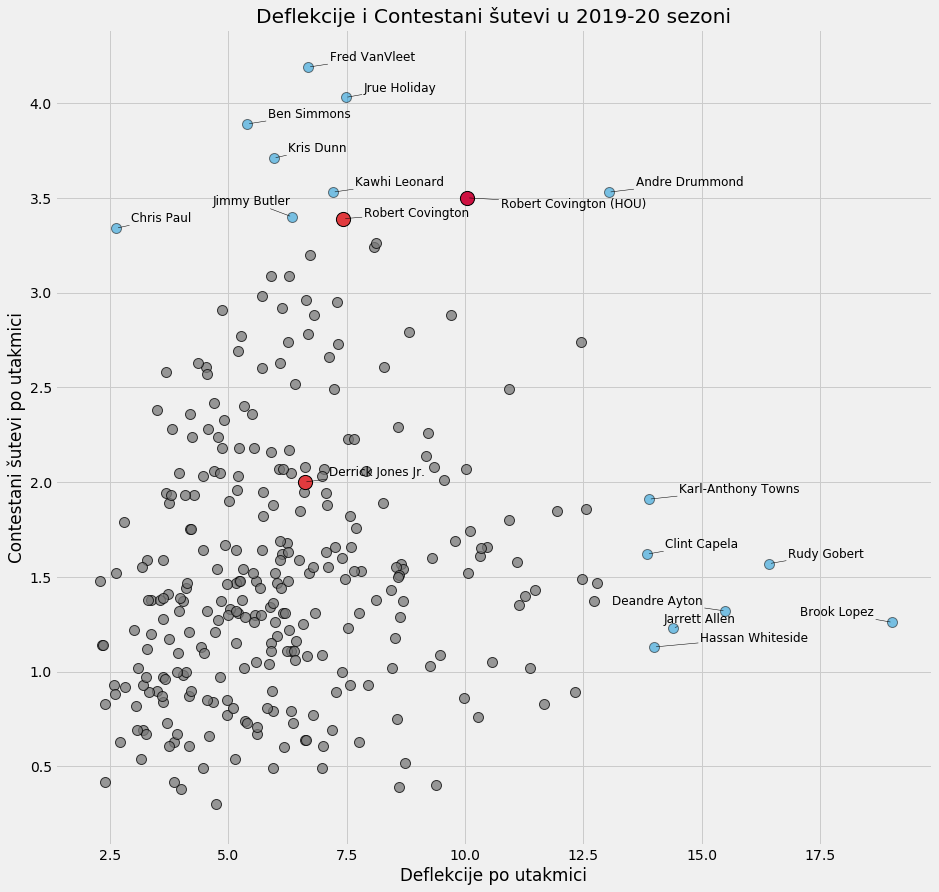

In [46]:
fig, ax = plt.subplots(figsize=(14, 14))


ax.scatter(x=top_performers.CONTESTED_SHOTS, y=top_performers.DEFLECTIONS, s=100, edgecolors='black', alpha=0.5, lw=1)
ax.scatter(x=other.CONTESTED_SHOTS, y=other.DEFLECTIONS, s=100, edgecolors='black', alpha=0.75, lw=1, color='#787878')
ax.scatter(x=roco_only.CONTESTED_SHOTS, y=roco_only.DEFLECTIONS, s=200, edgecolors='black', lw=1, color='#E03A3E')
ax.scatter(x=derrick_jones.CONTESTED_SHOTS, y=derrick_jones.DEFLECTIONS, s=200, edgecolors='black', lw=1, color='#E03A3E')
ax.scatter(x=roco_houston_only.CONTESTED_SHOTS, y=roco_houston_only.DEFLECTIONS, s=200, edgecolors='black', lw=1, color="#CE1141")

texts = []
for index in range(len(text_items)):
    item = text_items.iloc[index]
    texts.append(ax.text(x=item.CONTESTED_SHOTS, y=item.DEFLECTIONS, s=item.PLAYER_NAME, size=12))
    
texts.append(
    ax.text(
        x=roco_houston_only.iloc[0].CONTESTED_SHOTS,
        y=roco_houston_only.iloc[0].DEFLECTIONS,
        s="Robert Covington (HOU)",
        size=12
    )
)

texts.append(
    ax.text(
        x=derrick_jones.iloc[0].CONTESTED_SHOTS,
        y=derrick_jones.iloc[0].DEFLECTIONS,
        s="Derrick Jones Jr.",
        size=12
    )
)
ax.set_title("Deflekcije i Contestani šutevi u 2019-20 sezoni")
ax.set_xlabel("Deflekcije po utakmici")
ax.set_ylabel("Contestani šutevi po utakmici")
adjust_text(texts, arrowprops={'arrowstyle': '-', 'color': 'black'}, expand_points=(1.5, 1.5), expand_text=(1.3, 1.3))